In [1]:
# Import standard libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Import TensorFlow modules
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Import custom utilities
from utilities import (
    highlight_vif, calc_vif, highlight_p_values, calc_p_values, calc_correlation,
    print_title, print_label, print_footer,
    encode_categorical_data, encode_categorical_target
)

## Part 1: Data Preprocessing
___

#### Inspect Attrition Data Set

In [2]:
#  Import and read the attrition data
attrition_df = pd.read_csv('https://static.bc-edx.com/ai/ail-v-1-0/m19/lms/datasets/attrition.csv')

print("Shape:", attrition_df.shape)
attrition_df.head()

Shape: (1470, 27)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,Sales,1,2,Life Sciences,2,94,3,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,Research & Development,8,1,Life Sciences,3,61,2,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,Research & Development,2,2,Other,4,92,2,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,Research & Development,3,4,Life Sciences,4,56,3,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,Research & Development,2,1,Medical,1,40,3,...,3,4,1,6,3,3,2,2,2,2


In [3]:
# Determine the number of unique values in each column.
attrition_df.nunique()

Age                         43
Attrition                    2
BusinessTravel               3
Department                   3
DistanceFromHome            29
Education                    5
EducationField               6
EnvironmentSatisfaction      4
HourlyRate                  71
JobInvolvement               4
JobLevel                     5
JobRole                      9
JobSatisfaction              4
MaritalStatus                3
NumCompaniesWorked          10
OverTime                     2
PercentSalaryHike           15
PerformanceRating            2
RelationshipSatisfaction     4
StockOptionLevel             4
TotalWorkingYears           40
TrainingTimesLastYear        7
WorkLifeBalance              4
YearsAtCompany              37
YearsInCurrentRole          19
YearsSinceLastPromotion     16
YearsWithCurrManager        18
dtype: int64

### Seperate `X` **features** and `y` **targets** from original DataFrame
___

#### **`y` Targets:** Create `y` targets and inspect...

In [4]:
# Create y_df with the Attrition and Department columns

# Define the target set.
targets = ['Attrition', 'Department']

# Create a new DataFrame with just the target set.
y_df = attrition_df[targets]

# Display the first five rows of y_df
print("Shape:", y_df.shape)
y_df.head()

Shape: (1470, 2)


,Attrition,Department
0,Yes,Sales
1,No,Research & Development
2,Yes,Research & Development
3,No,Research & Development
4,No,Research & Development


In [5]:
# Inspect the target columns' balance
for column in y_df.columns:
    display(y_df[column].value_counts())

Attrition
No     1233
Yes     237
Name: count, dtype: int64

Department
Research & Development    961
Sales                     446
Human Resources            63
Name: count, dtype: int64

In [6]:
# Inspect the unique values of the object columns in the `y_df` DataFrame
print("Display the unique values in `y_df` columns", end='\n\n')

for object_column in y_df.columns:
    unique_values = y_df[object_column].unique()
    print(f'{object_column}:\n', f'{unique_values}\n', '='*65)

Display the unique values in `y_df` columns

Attrition:
 ['Yes' 'No']
Department:
 ['Sales' 'Research & Development' 'Human Resources']


#### **`X` Features:** Create `X` features and inspect...

In [7]:
# Create a list of at least 10 column names to use as X data
features = [
    'Age',
    'BusinessTravel',
    'DistanceFromHome',
    'Education',
    'EducationField',
    'EnvironmentSatisfaction',
    'HourlyRate',
    'JobInvolvement',
    'JobLevel',
    'JobRole',
    'JobSatisfaction',
    'MaritalStatus',
    'NumCompaniesWorked',
    'OverTime',
    'PercentSalaryHike',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'TotalWorkingYears',
    'TrainingTimesLastYear',
    'WorkLifeBalance',
    'YearsAtCompany',
    'YearsInCurrentRole',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager'
]

In [8]:
# Create a numeric and object data frame with our features for `X` keeping them separate
# This will allow us to encode the object data frame and then combine it with the numeric data frame
X_df_numeric = attrition_df[features].select_dtypes(include=['int64', 'float64']).copy()
X_df_obj = attrition_df[features].select_dtypes(include=['object']).copy()

# Display the first five rows of X_df_numeric
print("Feature `X` Numeric Data:")
display(X_df_numeric.head())

# Display the first five rows of X_df_obj
print("Feature `X` Object Data:")
display(X_df_obj.head())

Feature `X` Numeric Data:


,Age,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,1,2,2,94,3,2,4,8,11,3,1,0,8,0,1,6,4,0,5
1,49,8,1,3,61,2,2,2,1,23,4,4,1,10,3,3,10,7,1,7
2,37,2,2,4,92,2,1,3,6,15,3,2,0,7,3,3,0,0,0,0
3,33,3,4,4,56,3,1,3,1,11,3,3,0,8,3,3,8,7,3,0
4,27,2,1,1,40,3,1,2,9,12,3,4,1,6,3,3,2,2,2,2


Feature `X` Object Data:


,BusinessTravel,EducationField,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Life Sciences,Sales Executive,Single,Yes
1,Travel_Frequently,Life Sciences,Research Scientist,Married,No
2,Travel_Rarely,Other,Laboratory Technician,Single,Yes
3,Travel_Frequently,Life Sciences,Research Scientist,Married,Yes
4,Travel_Rarely,Medical,Laboratory Technician,Married,No


In [9]:
# Inspect the unique values of the object columns in the `X_df_obj` DataFrame
print("Display the unique values in `X_df_obj` columns", end='\n\n')

for object_column in X_df_obj.columns:
    unique_values = X_df_obj[object_column].unique()
    print(f'{object_column}:\n', f'{unique_values}\n', '='*65)

Display the unique values in `X_df_obj` columns

BusinessTravel:
 ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
EducationField:
 ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
JobRole:
 ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
MaritalStatus:
 ['Single' 'Married' 'Divorced']
OverTime:
 ['Yes' 'No']


### Feature `X` Engineering
___

#### Encode `X` Categorical Features...

In [10]:
# Convert your X data to numeric data types however you see fit

# Obtain list of categorical columns
categorical_columns = X_df_obj.columns.tolist()

# Perform one-hot encoding on all categorical columns creating a list of encoded dataframes
# Drop the first column to avoid multicollinearity
encoded_dfs = [encode_categorical_data(X_df_obj, col, drop_first=True) for col in categorical_columns]

# View the new encoded dataframes
for df in encoded_dfs:
    display(df.head(3))

,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,1
1,1,0
2,0,1


,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,0,1,0


,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0


,MaritalStatus_Married,MaritalStatus_Single
0,0,1
1,1,0
2,0,1


,OverTime_Yes
0,1
1,0
2,1


In [11]:
# Concatenate the numeric and encoded categorical columns into a single dataframe
X_df_raw = pd.concat([X_df_numeric] + encoded_dfs, axis=1)

# View updated features dataframe after concatenation
print("Shape:", X_df_raw.shape)
X_df_raw.head()

Shape: (1470, 38)


,Age,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,...,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes
0,41,1,2,2,94,3,2,4,8,11,...,0,0,0,0,0,1,0,0,1,1
1,49,8,1,3,61,2,2,2,1,23,...,0,0,0,0,1,0,0,1,0,0
2,37,2,2,4,92,2,1,3,6,15,...,1,0,0,0,0,0,0,0,1,1
3,33,3,4,4,56,3,1,3,1,11,...,0,0,0,0,1,0,0,1,0,1
4,27,2,1,1,40,3,1,2,9,12,...,1,0,0,0,0,0,0,1,0,0


#### Create new features ore modify existing features...

In [12]:
# Inspect the correlation matrix of the features
calc_correlation(X_df_raw, threshold=0.5)

,Age,JobLevel,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,JobRole_Manager
Age,1.000000,0.509604,0.003634,0.001904,0.680381,0.311309,0.212901,0.216513,0.202089,0.294248
JobLevel,0.509604,1.000000,-0.034730,-0.021222,0.782208,0.534739,0.389447,0.353885,0.375281,0.552744
PercentSalaryHike,0.003634,-0.034730,1.000000,0.773550,-0.020608,-0.035991,-0.001520,-0.022154,-0.011985,-0.005394
PerformanceRating,0.001904,-0.021222,0.773550,1.000000,0.006744,0.003435,0.034986,0.017896,0.022827,0.032050
TotalWorkingYears,0.680381,0.782208,-0.020608,0.006744,1.000000,0.628133,0.460365,0.404858,0.459188,0.465837
YearsAtCompany,0.311309,0.534739,-0.035991,0.003435,0.628133,1.000000,0.758754,0.618409,0.769212,0.330965
YearsInCurrentRole,0.212901,0.389447,-0.001520,0.034986,0.460365,0.758754,1.000000,0.548056,0.714365,0.167499
YearsSinceLastPromotion,0.216513,0.353885,-0.022154,0.017896,0.404858,0.618409,0.548056,1.000000,0.510224,0.224255
YearsWithCurrManager,0.202089,0.375281,-0.011985,0.022827,0.459188,0.769212,0.714365,0.510224,1.000000,0.164695
JobRole_Manager,0.294248,0.552744,-0.005394,0.032050,0.465837,0.330965,0.167499,0.224255,0.164695,1.000000


In [13]:
# Create X_df using your selected columns 
X_df = X_df_raw.copy()

# Show the data types for X_df
X_df.dtypes

Age                                 int64
DistanceFromHome                    int64
Education                           int64
EnvironmentSatisfaction             int64
HourlyRate                          int64
JobInvolvement                      int64
JobLevel                            int64
JobSatisfaction                     int64
NumCompaniesWorked                  int64
PercentSalaryHike                   int64
PerformanceRating                   int64
RelationshipSatisfaction            int64
StockOptionLevel                    int64
TotalWorkingYears                   int64
TrainingTimesLastYear               int64
WorkLifeBalance                     int64
YearsAtCompany                      int64
YearsInCurrentRole                  int64
YearsSinceLastPromotion             int64
YearsWithCurrManager                int64
BusinessTravel_Travel_Frequently    int64
BusinessTravel_Travel_Rarely        int64
EducationField_Life Sciences        int64
EducationField_Marketing          

**_Feature Creation_**

In [14]:
# Creating TenurRatio and CompanyTenureRatio columns that are ratios of YearsInCurrentRole, YearsAtCompany, and TotalWorkingYears
X_df['TenureRatio'] = (X_df['YearsInCurrentRole'] / X_df['YearsAtCompany']).fillna(0)
X_df['CompanyTenureRatio'] = (X_df['YearsAtCompany'] / X_df['TotalWorkingYears']).fillna(0)

# Display the updated X_df dataframe with the new columns
print("Preview Changes:")
X_df[['YearsInCurrentRole', 'YearsAtCompany', 'TotalWorkingYears', 'TenureRatio', 'CompanyTenureRatio']].head()

Preview Changes:


,YearsInCurrentRole,YearsAtCompany,TotalWorkingYears,TenureRatio,CompanyTenureRatio
0,4,6,8,0.666667,0.750000
1,7,10,10,0.700000,1.000000
2,0,0,7,0.000000,0.000000
3,7,8,8,0.875000,1.000000
4,2,2,6,1.000000,0.333333


**_Feature Selection_**

**Strong Positive and Negative Correlated Features**
- `JobLevel` and `TotalWorkingYears` (0.78): Employees with more years of experience are normally at higher job levels.
    - Keep `TotalWorkingYears` instead of `JobLevel` as it’s more general.
- `YearsAtCompany` and `YearsWithCurrManager` (0.77): Likely because a manager and an employee often remain aligned during their tenure.
- `YearsAtCompany` and `YearsInCurrentRole` (0.76): Long tenure often correlates with time in a role.
    - Keep `YearsAtCompany` instead of `YearsWithCurrManager` or `YearsInCurrentRole`.
- `PerformanceRating` and `PercentSalaryHike` (0.77): Might indicate employee growth or dissatisfaction, making them good predictors. May keep them.
- `TotalWorkingYears` and `Age` (0.68): Drop `Age` as it may make the model biased I think.


- removing `PerformanceRating` as it has an extremely high VIF and is likely constant across your dataset.

In [15]:
# Define the columns to drop after inspection
columns_to_drop = [
    'Age',
    'JobLevel',
    'YearsWithCurrManager',
    'YearsInCurrentRole',
    'YearsAtCompany',
    'TotalWorkingYears',
    'PerformanceRating'
]

# Drop the columns from X_df
X_df = X_df.drop(columns=columns_to_drop)

# Display the updated X_df dataframe
print("Shape:", X_df.shape)
X_df.head()

Shape: (1470, 33)


,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,TenureRatio,CompanyTenureRatio
0,1,2,2,94,3,4,8,11,1,0,...,0,0,0,1,0,0,1,1,0.666667,0.750000
1,8,1,3,61,2,2,1,23,4,1,...,0,0,1,0,0,1,0,0,0.700000,1.000000
2,2,2,4,92,2,3,6,15,2,0,...,0,0,0,0,0,0,1,1,0.000000,0.000000
3,3,4,4,56,3,3,1,11,3,0,...,0,0,1,0,0,1,0,1,0.875000,1.000000
4,2,1,1,40,3,2,9,12,4,1,...,0,0,0,0,0,1,0,0,1.000000,0.333333


In [16]:
# Inspect the correlation matrix of the features after feature engineering and modifications
calc_correlation(X_df)

,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsSinceLastPromotion,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,TenureRatio,CompanyTenureRatio
DistanceFromHome,1.000000,0.021042,-0.016075,0.031131,0.008783,-0.003669,-0.029251,0.040235,0.006557,0.044872,-0.036942,-0.026556,0.010029,0.005081,-0.020116,-0.024499,0.039294,0.013486,-0.007969,-0.014802,-0.024089,0.012369,-0.039190,0.011848,-0.022351,-0.010986,0.030761,-0.015994,0.030232,-0.027445,0.025514,0.017989,0.014031
Education,0.021042,1.000000,-0.027128,0.016775,0.042438,-0.011296,0.126317,-0.011111,-0.009118,0.018422,-0.025100,0.009819,0.054254,-0.008292,0.004126,0.013184,0.072405,-0.072335,0.038043,-0.026742,-0.005295,-0.063566,0.028453,-0.005290,0.049694,0.000709,0.053398,-0.091465,-0.001865,0.004168,-0.020322,0.023963,-0.115422
EnvironmentSatisfaction,-0.016075,-0.027128,1.000000,-0.049857,-0.008278,-0.006784,0.012594,-0.031701,0.007665,0.003432,-0.019359,0.027627,0.016194,-0.012624,0.008496,-0.024526,0.000479,-0.021299,0.064602,0.027713,-0.022014,-0.001533,0.010730,0.059178,-0.048689,0.001940,-0.024421,0.002949,-0.022180,0.009035,0.070132,0.008740,0.020625
HourlyRate,0.031131,0.016775,-0.049857,1.000000,0.042861,-0.071335,0.022157,-0.009062,0.001330,0.050263,-0.008548,-0.004607,-0.026716,-0.018819,0.027541,0.038759,0.004452,-0.020418,-0.042163,0.011283,-0.016189,0.018028,0.012659,-0.014394,-0.025128,0.020034,-0.011886,-0.018703,0.036432,-0.033436,-0.007782,-0.030886,-0.024529
JobInvolvement,0.008783,0.042438,-0.008278,0.042861,1.000000,-0.021476,0.015012,-0.017205,0.034297,0.021523,-0.015338,-0.014617,-0.024184,0.004424,0.026714,0.003228,-0.018657,0.017103,-0.011895,-0.004519,-0.004952,-0.022724,0.017112,-0.021939,0.015200,0.047604,-0.011413,-0.027282,0.028324,-0.045253,-0.003507,0.028685,-0.023926
JobSatisfaction,-0.003669,-0.011296,-0.006784,-0.071335,-0.021476,1.000000,-0.055699,0.020002,-0.012454,0.010690,-0.005779,-0.019459,-0.018214,0.027117,-0.036562,0.052004,-0.023528,-0.022645,0.003380,-0.019795,-0.029681,-0.015710,-0.005620,-0.013747,-0.006217,0.020503,0.012604,0.001413,-0.010315,0.024571,0.024539,-0.001451,0.024784
NumCompaniesWorked,-0.029251,0.126317,0.012594,0.022157,0.015012,-0.055699,1.000000,-0.010238,0.052733,0.030075,-0.066054,-0.008366,-0.036814,-0.039718,0.032401,-0.006131,-0.018611,0.024826,-0.012870,-0.013819,0.020578,-0.021121,0.042125,0.009580,0.097925,-0.043981,0.005913,-0.104494,-0.016142,-0.019161,-0.020786,0.015131,-0.523513
PercentSalaryHike,0.040235,-0.011111,-0.031701,-0.009062,-0.017205,0.020002,-0.010238,1.000000,-0.040490,0.007528,-0.005221,-0.003280,-0.022154,-0.006675,-0.018649,0.010209,-0.027726,0.029116,0.019297,-0.042701,-0.021032,-0.020628,-0.005394,0.034682,-0.017017,0.032537,-0.046683,0.031102,0.020895,-0.001386,-0.005433,-0.002608,-0.014931
RelationshipSatisfaction,0.006557,-0.009118,0.007665,0.001330,0.034297,-0.012454,0.052733,-0.040490,1.000000,-0.045952,0.002497,0.019604,0.033493,0.028500,-0.038640,-0.019973,-0.006580,0.030494,-0.020305,-0.011044,0.044169,-0.010691,0.025638,0.003640,-0.005492,-0.003116,-0.004836,-0.024859,-0.043382,0.040817,0.048493,-0.007434,-0.017850
StockOptionLevel,0.044872,0.018422,0.003432,0.050263,0.021523,0.010690,0.030075,0.007528,-0.045952,1.000000,0.011274,0.004129,0.014352,-0.016142,-0.005303,-0.017993,0.022560,0.033750,-0.042100,-0.024560,-0.009864,0.013386,-0.015637,0.007735,0.015807,-0.011635,0.015756,-0.048067,0.225574,-0.63

In [17]:
# Inspect the Variance Inflation Factor (VIF) for the features in the X DataFrame
vif = calc_vif(X_df)

vif.style.apply(lambda x: highlight_vif(x, threshold=10))

,VIF
OverTime_Yes,1.428424
JobRole_Human Resources,1.579331
JobRole_Research Director,1.599342
JobRole_Sales Representative,1.747301
JobRole_Manager,1.781805
YearsSinceLastPromotion,1.852319
JobRole_Manufacturing Director,2.076358
DistanceFromHome,2.309918
BusinessTravel_Travel_Frequently,2.815459
JobRole_Laboratory Technician,2.966384


### Data Splitting: Split data into Train and Test sets
___

#### Train Test Split `X` features and `y` target...

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=78)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1102, 33)
X_test shape: (368, 33)
y_train shape: (1102, 2)
y_test shape: (368, 2)


#### Scale Features `X` ...

In [19]:
# Create a StandardScaler
X_scaler = StandardScaler()

# Fit the StandardScaler to the training data
X_scaler.fit(X_train)

# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


#### Encode `y` targets...

In [20]:
# Create a OneHotEncoder for the Department column
department_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder to the training data
department_encoder.fit(y_train['Department'].values.reshape(-1, 1))

# Create two new variables by applying the encoder
# to the training and testing data
department_encoded_train = department_encoder.transform(y_train['Department'].values.reshape(-1, 1))
department_encoded_test = department_encoder.transform(y_test['Department'].values.reshape(-1, 1))

print("Column Names:", department_encoder.get_feature_names_out(['Department']), sep='\n', end='\n\n')
print("Shape:", department_encoded_train.shape)
print(department_encoded_train)

Column Names:
['Department_Human Resources' 'Department_Research & Development'
 'Department_Sales']

Shape: (1102, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [21]:
# Create a OneHotEncoder for the Attrition column
attrition_encoder = OneHotEncoder(sparse_output=False)

# Fit the encoder to the training data
attrition_encoder.fit(y_train['Attrition'].values.reshape(-1, 1))

# Create two new variables by applying the encoder
# to the training and testing data
attrition_encoded_train = attrition_encoder.transform(y_train['Attrition'].values.reshape(-1, 1))
attrition_encoded_test = attrition_encoder.transform(y_test['Attrition'].values.reshape(-1, 1))

print("Column Names:", attrition_encoder.get_feature_names_out(['Attrition']), sep='\n', end='\n\n')
print("Shape:", attrition_encoded_train.shape)
print(attrition_encoded_train)

Column Names:
['Attrition_No' 'Attrition_Yes']

Shape: (1102, 2)
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


## Part 2: Create, Compile, and Train the Model
___

#### Define Number of Nodes for each of our Model's layers

In [22]:
# Find the number of columns in the X training data
input_nodes = X_train_scaled.shape[1]

# Find the number of columns in the y training data
num_classes = {
    'Department': department_encoded_train.shape[1],
    'Attrition': attrition_encoded_train.shape[1]
}

print("Input Nodes:", input_nodes)
print("Number of Classes:", num_classes)

Input Nodes: 33
Number of Classes: {'Department': 3, 'Attrition': 2}


In [23]:
# Define the number of nodes in the hidden layers

hidden_layer_nodes = {
    'shared': [
        input_nodes * 2,
        input_nodes * 4
    ],
    'department': [
        input_nodes * 4,
    ],
    'attrition': [
        input_nodes * 4,
    ]
}

#### Model Creation: Create the Neural Network model with Branches

In [25]:
class AttritionModel:
    def __init__(self, input_nodes, num_classes, hidden_layer_nodes):
        self.input_shape = (input_nodes,)
        self.num_classes = num_classes
        self.hidden_layer_nodes = hidden_layer_nodes


    def create_shared_layers(self, input_layer):
        # Create at least two shared layers

        shared_layer1 = layers.Dense(
            hidden_layer_nodes['shared'][0],
            activation='relu',
            name='shared_1'
        )(input_layer)

        shared_layer2 = layers.Dense(
            hidden_layer_nodes['shared'][1],
            activation='relu',
            name='shared_2'
        )(shared_layer1)

        return shared_layer2


    def build_branches(self, shared_layer):
        # Create a branch for Department
        # with a hidden layer and an output layer

        # Create the hidden layer
        department_branch = layers.Dense(
            hidden_layer_nodes['department'][0],
            activation='relu',
            name='department_hidden'
        )(shared_layer)

        # Create the output layer
        department_output = layers.Dense(
            self.num_classes['Department'],
            activation='softmax',
            name='department_output'
        )(department_branch)

        # Create a branch for Attrition
        # with a hidden layer and an output layer

        # Create the hidden layer
        attrition_branch = layers.Dense(
            hidden_layer_nodes['attrition'][0],
            activation='relu',
            name='attrition_hidden'
        )(shared_layer)

        # Create the output layer
        attrition_output = layers.Dense(
            self.num_classes['Attrition'],
            activation='softmax',
            name='attrition_output'
        )(attrition_branch)

        return department_output, attrition_output


    def build_model(self):
        # Create the input layer
        input_layer = layers.Input(
            shape=self.input_shape,
            name='input'
        )

        # Create at least two shared layers
        shared_layer = self.create_shared_layers(input_layer)

        # Create the output layers
        department_output, attrition_output = self.build_branches(shared_layer)

        # Create the model
        model = Model(
            inputs=input_layer,
            outputs={
                'attrition_output': attrition_output,
                'department_output': department_output,
            },
            name='attrition_model'
        )
        return model

In [28]:
# Create the model using our Custom Model class
model = AttritionModel(input_nodes, num_classes, hidden_layer_nodes).build_model()

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'attrition_output': 'categorical_crossentropy',
        'department_output': 'categorical_crossentropy',
    },
    metrics={
        'attrition_output': 'accuracy',
        'department_output': 'accuracy',
    }
)

# Summarize the model
model.summary()

Model: "attrition_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 33)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_1 (Dense)    │ (None, 66)        │      2,244 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_2 (Dense)    │ (None, 132)       │      8,844 │ shared_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attrition_hidden    │ (None, 132)       │     17,556 │ shared_2[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ department_hidden   │ (None, 132)       │     17,556 │ shared_2[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attrition_output    │ (None, 2)         │        266 │ attrition_hidden… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ department_output   │ (None, 3)         │        399 │ department_hidde… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,865 (183.07 KB)

 Trainable params: 46,865 (183.07 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training: Train the model using our training dataset

In [30]:
# Train the model
fit_model = model.fit(
    x=X_train_scaled,
    y={
        'attrition_output': attrition_encoded_train,
        'department_output': department_encoded_train
    },
    batch_size=100,
    epochs=100,
    validation_data=(
        X_test_scaled,
        {
            'attrition_output': attrition_encoded_test,
            'department_output': department_encoded_test
        }
    )
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - attrition_output_accuracy: 0.7997 - attrition_output_loss: 0.5452 - department_output_accuracy: 0.6511 - department_output_loss: 0.8131 - loss: 1.3519 - val_attrition_output_accuracy: 0.8723 - val_attrition_output_loss: 0.3749 - val_department_output_accuracy: 0.7473 - val_department_output_loss: 0.6312 - val_loss: 1.0201
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - attrition_output_accuracy: 0.8218 - attrition_output_loss: 0.4473 - department_output_accuracy: 0.8423 - department_output_loss: 0.4833 - loss: 0.9378 - val_attrition_output_accuracy: 0.8750 - val_attrition_output_loss: 0.3744 - val_department_output_accuracy: 0.8560 - val_department_output_loss: 0.3983 - val_loss: 0.7813
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - attrition_output_accuracy: 0.8291 - attrition_output_loss: 0.3986 - department_output_accuracy: 0.9136 - department_output_loss: 0.2825 - loss: 0.6883 - val_attrition_output_accuracy: 0.8696 -

#### Model Evaluation: Evaluate the model performance

In [32]:
# Evaluate the model with the testing data
results = model.evaluate(
    x=X_test_scaled,
    y={
        'attrition_output': attrition_encoded_test,
        'department_output': department_encoded_test,
    },
    return_dict=True
)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - attrition_output_accuracy: 0.8501 - attrition_output_loss: 1.0885 - department_output_accuracy: 0.9695 - department_output_loss: 0.1547 - loss: 1.2512


```json
{
    // Improve these metrics
    "loss": 4.162380218505859,
    "department_output_loss": 3.114327907562256,
    "attrition_output_loss":  1.0480519533157349,
    "attrition_output_accuracy": 0.5271739363670349,
    "department_output_accuracy": 0.826086938381195,
}
```

In [33]:
# Print the accuracy for both department and attrition
print(json.dumps(results, indent=4))

{
    "attrition_output_accuracy": 0.8586956262588501,
    "attrition_output_loss": 1.1332639455795288,
    "department_output_accuracy": 0.9646739363670349,
    "department_output_loss": 0.20727042853832245,
    "loss": 1.3919100761413574
}


In [34]:
history_df = pd.DataFrame(fit_model.history)

history_df.index += 1

In [35]:
last_epoch_df = history_df.iloc[-1]

metrics = ['attrition_output', 'department_output', 'loss']
columns = ['loss', 'validation_loss', 'accuracy', 'validation_accuracy']

reshaped_data = {}
for metric in metrics:
    reshaped_data[metric] = [
        last_epoch_df.get(f'{metric}_loss', last_epoch_df.get('loss', None)),
        last_epoch_df.get(f'val_{metric}_loss', last_epoch_df.get('val_loss', None)),
        last_epoch_df.get(f'{metric}_accuracy', None),
        last_epoch_df.get(f'val_{metric}_accuracy', None)
    ]

reshaped_df = pd.DataFrame(reshaped_data, index=columns).T

reshaped_df

,loss,validation_loss,accuracy,validation_accuracy
attrition_output,0.000520,1.160195,1.0,0.858696
department_output,0.000121,0.209120,1.0,0.964674
loss,0.000682,1.391910,NaN,NaN


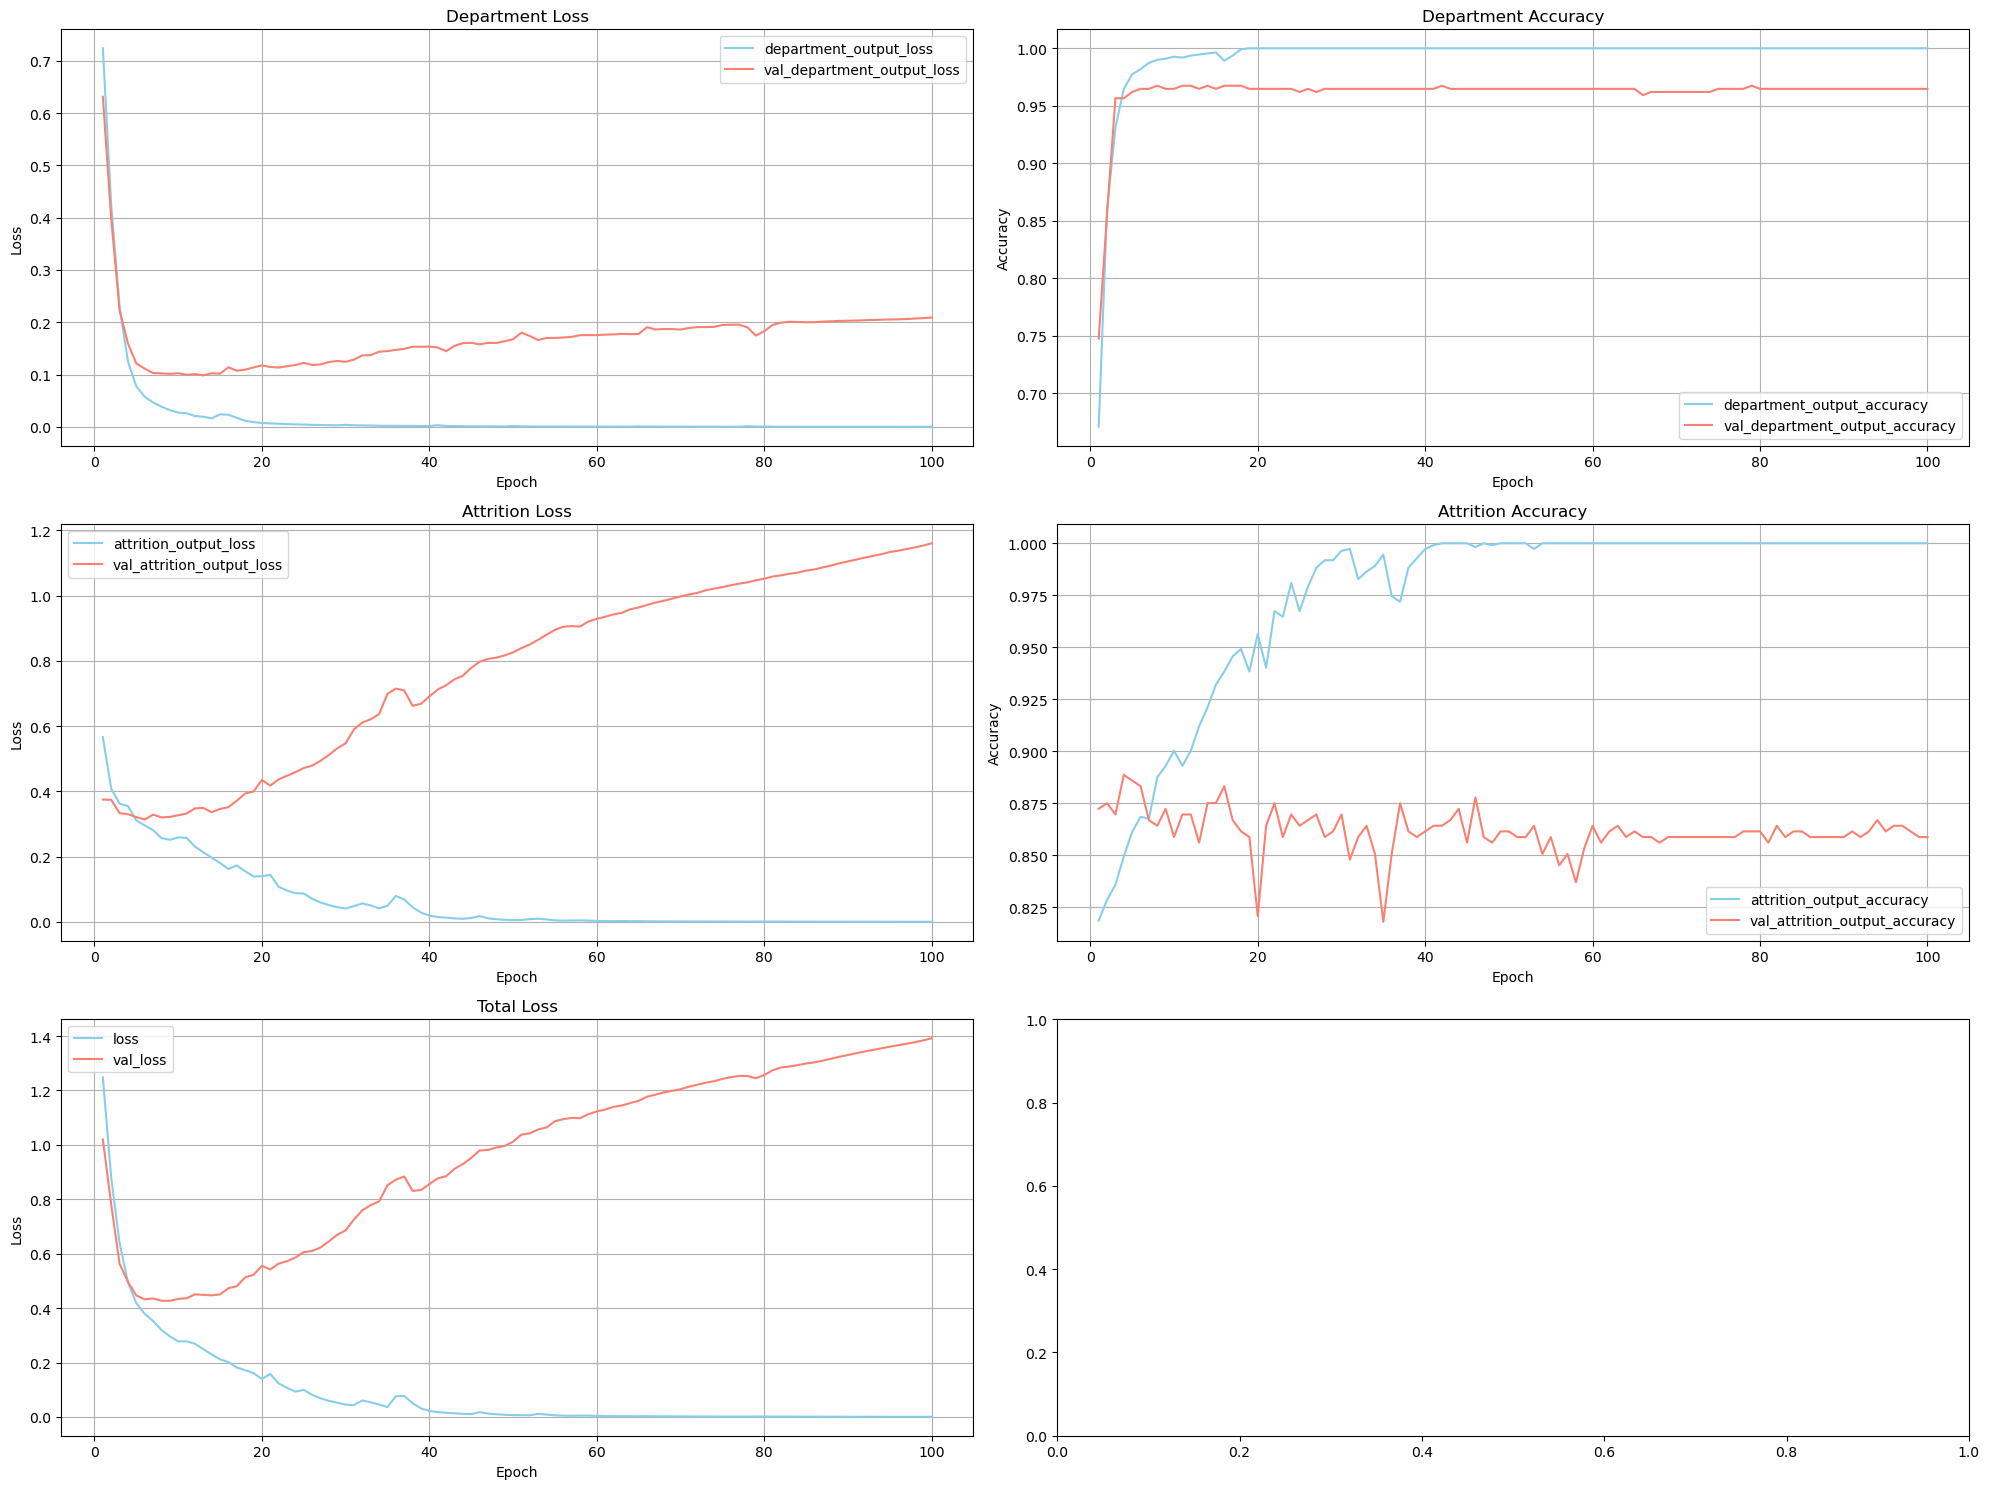

In [36]:
def plot_metric(history_df, metric, title, xlabel, ylabel, ax, style=['skyblue', 'salmon']):
    history_df.plot(
        y=[f'{metric}', f'val_{metric}'],
        title=title,
        xlabel=xlabel,
        ylabel=ylabel,
        legend=True,
        grid=True,
        style=style,
        ax=ax
    )

fig, ax = plt.subplots(3, 2, figsize=(20, 15))


plot_metric(history_df, 'department_output_loss', 'Department Loss', 'Epoch', 'Loss', ax[0, 0])
plot_metric(history_df, 'department_output_accuracy', 'Department Accuracy', 'Epoch', 'Accuracy', ax[0, 1])
plot_metric(history_df, 'attrition_output_loss', 'Attrition Loss', 'Epoch', 'Loss', ax[1, 0])
plot_metric(history_df, 'attrition_output_accuracy', 'Attrition Accuracy', 'Epoch', 'Accuracy', ax[1, 1])
plot_metric(history_df, 'loss', 'Total Loss', 'Epoch', 'Loss', ax[2, 0])

plt.tight_layout()
plt.show()


## Part 3: Summary
___

In the provided space below, briefly answer the following questions.

1. Is accuracy the best metric to use on this data? Why or why not?

2. What activation functions did you choose for your output layers, and why?

3. Can you name a few ways that this model might be improved?

YOUR ANSWERS HERE

1. 
2. 
3. 